In [1]:
import math
from typing import Any
from typing import Optional

import laspy
import matplotlib.pyplot as plt
import numpy as np
import rasterio.fill
import scipy as sp
from tqdm import tqdm

import raster

In [2]:
# Load the point cloud.
with laspy.open("lidar.laz") as src:
    data = src.read()

### Reflectance Field Rasterization

In [3]:
# Extract the necessary point attributes.
# NOTE: The elevation is used to estimate the surface normals.
ELEVATION = data["z"].scaled_array()

REFLECTANCE = data["Reflectance"].scaled_array()
# Convert the unit from dB to the underlying ratio.
REFLECTANCE = (10 ** (0.1 * REFLECTANCE))
# Clip erroneous values corresponding to non-Lambertian surfaces.
REFLECTANCE = REFLECTANCE.clip(max=1)

In [ ]:
# Compute the bounding box of the point cloud.
BBOX = [*data.header.mins[:2], *data.header.maxs[:2]]

# Specify the output raster resolution.
# NOTE: Use a sensible default resolution given the nominal AN4 point density (10 points/m^{2}) and BM5 imagery resolution (~8 cm - the actual resolution is 8 + 1.67e-8 cm, presumably due to floating-point rounding errors).
RESOLUTION: Optional[float] = 0.32
if RESOLUTION is None:
    area = (BBOX[2] - BBOX[0]) * (BBOX[3] - BBOX[1])
    density = len(data) / area

    # NOTE: This is the "natural" resolution of the point cloud, assuming perfectly uniform point distribution in all directions.
    RESOLUTION = math.sqrt(density) ** -1
    # Do not exceed the BM5 resolution.
    RESOLUTION = max(RESOLUTION, 0.08)

# Initialize the output raster.
ras = raster.Raster(RESOLUTION, bbox=BBOX)

# Compute the raster cells.
rows, cols = np.mgrid[0:ras.height, 0:ras.width]

cells_x = BBOX[0] + (cols + 0.5) * RESOLUTION
cells_y = BBOX[3] - (rows + 0.5) * RESOLUTION

cells = np.vstack([cells_x.ravel(), cells_y.ravel()]).transpose()

In [ ]:
# Initialize the spatial index of the point cloud.
index = sp.spatial.KDTree(np.vstack([data.x, data.y]).transpose())

In [ ]:
# TODO: Cache the neighbor and distance queries.
# TODO: Add multithreading.
def query(index: sp.spatial.KDTree, cells: np.ndarray[tuple[Any, 2], np.dtype[np.number]]) -> tuple[
    np.ndarray[tuple[Any,], np.dtype[np.object_]], np.ndarray[tuple[Any,], np.dtype[np.object_]]]:
    # Compute the cell neighbors.
    neighbors = index.query_ball_point(cells,
                                       r=RESOLUTION,
                                       workers=-1,
                                       # NOTE: Multi-point query results are sorted by neighbor index, which unnecessarily impacts performance.
                                       return_sorted=False)

    # Compute the distances to the cell neighbors.
    distances = np.empty_like(neighbors)
    for i, (cell, neighbor) in tqdm(enumerate(zip(cells, neighbors)),
                                    desc="Cell-to-Neighbor Distances",
                                    total=len(neighbors),
                                    unit="cells"):
        # NOTE: Distance arrays must be 1D.
        distances[i] = sp.spatial.distance.cdist(cell[None, :], index.data[neighbor]).ravel()

    return neighbors, distances

In [ ]:
neighbors, distances = query(index, cells)

In [ ]:
# TODO: Add multithreading.
# Interpolate the attribute value at the raster cells.
ras_data = np.full_like(neighbors, fill_value=np.nan, dtype=np.float32)
for i, (neighbor, distance) in tqdm(enumerate(zip(neighbors, distances)),
                                    desc="Rasterization",
                                    total=len(neighbors),
                                    unit="cells"):
    if not neighbor:
        # The cell is empty.
        continue
    if np.any(distance == 0):
        # The cell is a member of the point cloud; read the corresponding attribute value.
        ras_data[i] = REFLECTANCE[neighbor[np.argsort(distance)[0]]]
    else:
        # IDW
        ras_data[i] = np.average(REFLECTANCE[neighbor], weights=distance ** -2)

# Shape the data into a raster form.
ras_data = ras_data.reshape([ras.height, ras.width])

# Fill the empty cells.
# TODO: Detect the no-data value automatically.
ras_data = rasterio.fill.fillnodata(ras_data, mask=np.logical_not(np.isnan(ras_data)))

# Overwrite the raster data.
ras._data = ras_data
ras.save("lidar.refl.tif")

### Surface Normal Vector Computation

In [ ]:
# Compute the six nearest neighbors of each point.
# NOTE: Since the queries are the index itself, they are also returned as "neighbors" to themselves, and thus the seven instead of six nearest neighbors must actually be found.
neighbors = index.query(index.data, k=6 + 1, workers=-1)[1]

In [ ]:
# Fit a plane to the local neighborhood of each point.
normals = np.zeros([index.n, 3])
for i, neighbor in tqdm(enumerate(neighbors), desc="Normal Computation", total=len(neighbors), unit="points"):
    # Gather the local point neighborhood.
    pts = np.hstack([index.data[neighbor], ELEVATION[neighbor][:, None]])

    # Compute the relative point elevation of the neighborhood with respect to the corresponding query.
    # NOTE: The first point in the neighborhood is the seed, by convention.
    rel_z = np.abs(pts[0, -1] - pts[:, -1])
    # Discard outliers from the neighborhood.
    # TODO: Fine tune the cutoff threshold.
    pts = pts[np.where(rel_z < 0.1)]

    # TODO: Is this really necessary?
    if len(pts) < 3:
        # The neighborhood is erroneous.
        continue

    # NOTE: The final rotation matrix is returned in its Hermitian form.
    # TODO: Consider using the neighborhood covariance matrix.
    n = np.linalg.svd(pts - np.mean(pts, axis=0))[-1][-1]
    if n[-1] < 0:
        # The normal is pointing to the ground.
        n *= -1

    normals[i] = n

In [ ]:
np.save("lidar.norm", normals)

### Radiometric Calibration

In [4]:
normals = np.load("lidar.norm.npy")

In [5]:
# Get the scan angle.
# TODO: Explain the scan angle conversion.
# https://github.com/ASPRSorg/LAS/issues/41
scan_angle = np.radians(data.scan_angle * 0.006)

In [6]:
# Compute the refracted laser beam vectors.
# NOTE: This operation is the result of rotating the nadir-pointing ``k`` vector by the scan angle around the y-axis (i.e., the along-track direction), and then reversing its direction to point towards the sky.
refracted_beams = np.vstack([np.sin(scan_angle), np.zeros(len(scan_angle)), np.cos(scan_angle)]).transpose()

In [7]:
# NOTE: The beam vectors may not be normalized due to floating-point rounding errors, and thus the complete trigonometric calculation is necessary.
incidence_cosines = ((refracted_beams * normals).sum(axis=1)) / np.linalg.norm(refracted_beams, axis=1)

Found 191770 points associated with an erroneous incidence cosine value.


Text(0.5, 1.0, 'Erroneous Incident Cosine Values')

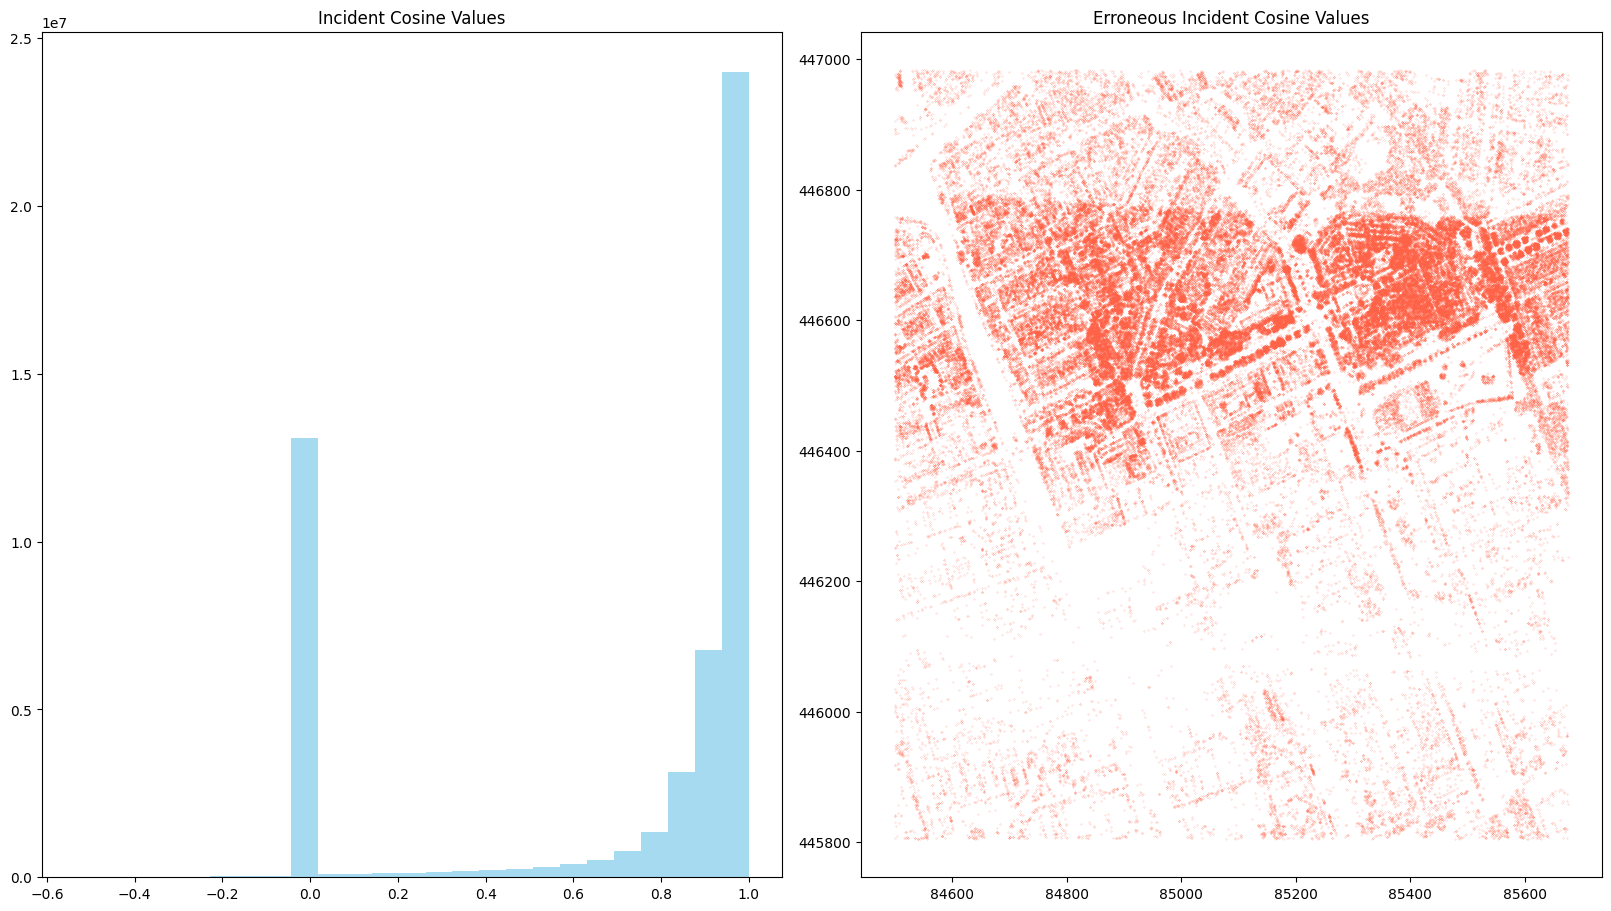

In [12]:
# Check the value quality.
bad_cosines = data[(incidence_cosines < 0)].xyz

# Count and report on the erroneous values.
print(f"Found {len(bad_cosines)} points associated with an erroneous incidence cosine value.")

fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(16, 9))

# Visualize the value distribution.
# TODO: Compute the number of bins automatically using Doane's formula.
# https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width
axs[0].hist(incidence_cosines, alpha=0.75, bins=25, color='skyblue')
axs[0].set_title('Incident Cosine Values')

# Visualize the erroneous values.
axs[1].scatter(bad_cosines[:, 0], bad_cosines[:, 1], alpha=0.75, color="tomato", marker=".", s=0.1)
axs[1].set_title('Erroneous Incident Cosine Values')